In [6]:
import datetime
import os
import re
import csv
from lib_log_parse import load_parsed_logs, parse
from typing import List, Optional, Tuple
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
log_paths = [
    "../data/2022-12-08_hydra_dial_down",
    "../data/2023-01-31_plain",
]

In [4]:
for path in log_paths:
    values = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        if os.path.exists(file_path + ".p"):
            print(f"Skipping: {file_path}")
            continue

        values += [[file_path]]

    with mp.Pool() as pool:
        pool.map(parse, values)

Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-5.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-4.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-6.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-3.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-2.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-0.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-1.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-2.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-3.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-1.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-0.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-4.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-5.log
Skipping: ../data/2022-12

In [5]:
results_map = {}
files_map = {}
for i, path in enumerate(log_paths):
    files = []
    for fn in os.listdir(path):
        file_path = os.path.join(path, fn)
        if not os.path.isfile(file_path):
            continue

        if not fn.endswith(".log"):
            continue

        files += [file_path]

    pool = mp.Pool(mp.cpu_count())
    results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))
    if i == 0:
        results_map["hydra"] = results
        files_map["hydra"] = files
    elif i == 1:
        results_map["gala"] = results
        files_map["gala"] = files
    else:
        raise Exception("asdf")


log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-2.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-2.log
Took 0:00:29.329845
log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-5.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-5.log
Took 0:00:11.237908
log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-0.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-0.log
Took 0:00:30.619141
log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-6.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-6.log
Took 0:00:09.195918
log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-1.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-1.log
Took 0:00:31.371185
log_files ['../data/2022-12-08_hydra_dial_down/nodes-list-ignore-hydras-node-4.log']
Loading  ../data/2022-12-08_hydra_dial_down/nodes-

In [7]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/plain-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/nodes-list-fleet-(\d)-node-(\d).log", origin)
        if match is None:
            match = re.search(r".*\/nodes-list-ignore-hydras-node-(\d).log", origin)
            if match is None:
                return None
            return 3, int(match.group(1))

        fleet = int(match.group(1))
        node = int(match.group(2))
        return fleet, node

    return 0, int(match.group(1))



def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    if fleet == 0:
        return log_no_to_region[node]
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    elif fleet == 3:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
        elif node == 7:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")

results_by_region_map = {}

for key, files in files_map.items():
    results_by_region_map[key] = {}
    for idx, f in enumerate(files):
        region = region_from_origin(f)

        if not region in results_by_region_map[key]:
            results_by_region_map[key][region] = []
        results_by_region_map[key][region] += [results_map[key][idx][0]]

In [8]:
df_retrievals_dict_map ={}
df_publications_dict_map ={}
for key, files in files_map.items():
    df_publications_dict_map[key] = {
        "total_publication_duration": []
    }
    df_retrievals_dict_map[key] = {
        "node": [],
        "region": [],
        "started_at": [],
        "overall_retrieval_duration": [],
        "dht_walks_duration": [],
        "find_first_provider_duration": [],
        "connected_duration": [],
        "received_first_HAVE_duration": [],
        "content_fetch_duration": [],
        "find_provider_queries_count": [],
        "has_error": [],
    }
    publications: List[Publication] = []
    retrievals: List[Retrieval] = []
    for parsed_log in results_map[key]:
        for log in parsed_log:
            publications += log.publications
            retrievals += log.retrievals

    # Remove all retrievals that are marked as invalid
    retrievals = list(
        filter(lambda ret: not ret.marked_as_incomplete, retrievals))
    retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

    for pub in publications:
        try:
            df_publications_dict_map[key]["total_publication_duration"] += [pub.duration_total_publication().total_seconds()]
        except:
            print("AAH")
            continue

    for ret in retrievals:
        if ret.stream_opened_at is None or ret.connected_at is None:
            print("skip", ret.stream_opened_at, ret.connected_at)
            continue

        node = log_origin(ret.origin)
        region = region_from_origin(ret.origin)
        # region = region_from_origin(ret.origin)
        if region is None:
            raise Exception("AHH")

        df_retrievals_dict_map[key]["started_at"] += [ret.dial_started_at]
        df_retrievals_dict_map[key]["node"] += [node]
        df_retrievals_dict_map[key]["region"] += [region]
        df_retrievals_dict_map[key]["has_error"] += [ret.done_retrieving_error is not None]

        overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
        # simulate peer record retrieval by adding the DHT walk duration
        overall_retrieval_duration += ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["overall_retrieval_duration"] += [overall_retrieval_duration]

        # simulate peer record retrieval by adding the DHT walk duration
        dht_walks_duration = 2 * ret.get_dht_walk_duration()
        df_retrievals_dict_map[key]["dht_walks_duration"] += [dht_walks_duration]

        df_retrievals_dict_map[key]["find_first_provider_duration"] += [(
                                                                       ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
        df_retrievals_dict_map[key]["find_provider_queries_count"] += [
            len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]
        df_retrievals_dict_map[key]["connected_duration"] += [(ret.connected_at - ret.get_providers_queries_started_at).total_seconds()]
        df_retrievals_dict_map[key]["received_first_HAVE_duration"] += [(ret.received_first_HAVE_at - ret.get_providers_queries_started_at).total_seconds()]

    # df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict_map[key])

skip None 2022-11-26 01:27:56.673828+00:00
skip None 2022-11-26 03:13:57.461092+00:00
skip None 2022-11-27 09:26:22.142936+00:00
skip None 2022-11-28 03:40:53.378387+00:00
skip None 2022-11-28 03:51:49.151898+00:00
skip None 2022-11-28 21:49:54.634930+00:00
skip None 2022-11-29 09:15:23.821383+00:00
skip None 2022-11-30 04:57:03.082503+00:00
skip None 2022-12-01 07:42:08.747063+00:00
skip None 2022-12-03 14:31:35.642540+00:00
skip None 2022-12-07 16:45:41.432303+00:00
skip None 2022-12-01 21:24:29.975931+00:00
skip None 2022-12-05 01:38:56.754089+00:00
skip None 2022-11-26 13:08:16.063403+00:00
skip None 2022-11-26 16:13:45.958209+00:00
skip None 2022-11-26 19:48:54.547618+00:00
skip None 2022-11-26 20:33:48.770438+00:00
skip None 2022-11-27 08:41:53.912341+00:00
skip None 2022-11-29 06:56:58.477133+00:00
skip None 2022-12-02 20:57:36.165682+00:00
skip None 2022-11-26 20:33:48.931369+00:00
skip None 2022-11-27 08:41:54.222476+00:00
skip None 2022-11-27 12:01:38.543387+00:00
skip None 2

In [9]:
df_retrievals_dict_map.keys()

dict_keys(['hydra', 'gala'])

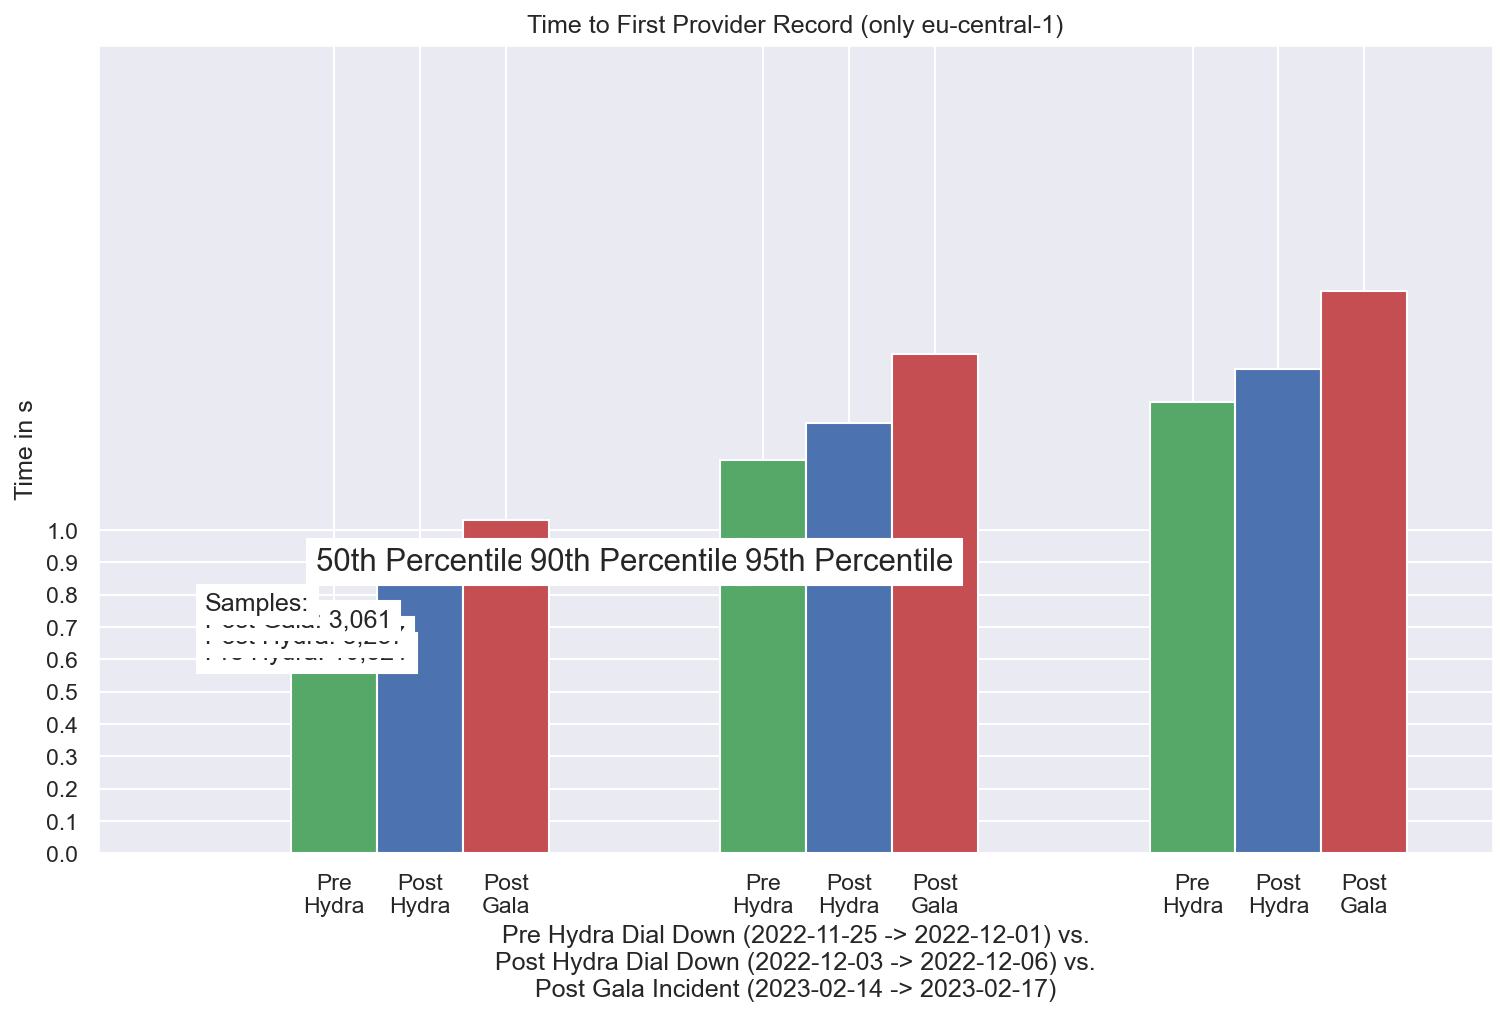

In [37]:
width = 0.2

fig, ax = plt.subplots(figsize=[12, 7], dpi=150)

xticks = []
labels = []
retrievals_by_galas = {
    "hydra": pd.DataFrame.from_dict(df_retrievals_dict_map["hydra"]),
    "gala": pd.DataFrame.from_dict(df_retrievals_dict_map["gala"]),
}
region = "eu_central_1"
sample_counts = {}
for i, percentile in enumerate([50, 90, 95]):

    dat = retrievals_by_galas["hydra"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] <= '2022-12-01']
    dat = dat["find_first_provider_duration"]
    sample_counts["Pre Hydra"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i - width, with_percentile, width, color="g")

    dat = retrievals_by_galas["hydra"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= '2022-12-03']
    dat = dat[dat["started_at"] <= '2022-12-06']
    dat = dat["find_first_provider_duration"]
    sample_counts["Post Hydra"] = len(dat)
    with_percentile = np.percentile(dat, percentile)
    ax.bar(i, with_percentile, width, color="b")

    dat = retrievals_by_galas["gala"]
    dat = dat[dat["region"] == region]
    dat = dat[dat["started_at"] >= "2023-02-14"]
    dat = dat[dat["started_at"] <= "2023-02-17"]
    dat = dat["find_first_provider_duration"]
    sample_counts["Post Gala"] = len(dat)
    without_percentile = np.percentile(dat, percentile)
    ax.bar(i + width, without_percentile, width, color="r")

    # ax.text(i, without_percentile + 0.05, f"{without_percentile / with_percentile - 1:.1%}\nincrease", ha="center", va="center", size=15)

    ax.text(i/2, 0.9, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [ i - width, i, i+ width]
    labels += ["Pre\nHydra", "Post\nHydra", "Post\nGala"]

for i, key in enumerate(sample_counts):
    ax.text(-0.5, 0.05*i + 0.6, f"{key}: {format(sample_counts[key], ',')}",bbox=dict(fc="w", lw=1))

ax.text(-0.5, 0.75, "Samples:",bbox=dict(fc="w", lw=1))

ax.set_title(f"Time to First Provider Record (only eu-central-1)")
ax.set_xlabel("Pre Hydra Dial Down (2022-11-25 -> 2022-12-01) vs.\nPost Hydra Dial Down (2022-12-03 -> 2022-12-06) vs.\nPost Gala Incident (2023-02-14 -> 2023-02-17)")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(-0.75, 2.5)
ax.set_ylim(0, 1)

ax.set_xticks(xticks, labels)
